In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import statistics as stat
import ipywidgets as widgets
from IPython.display import display
from enhancement_analysis import *
from fit_functions import *

%matplotlib inline

First, import the frequency data (an array of rows, each row representing the frequency of the MixTrain during the scan), the Yb data (the integrated OD of the in cell Yb absorption at that frequency), and the YbOH data (the integrated OD of the YbOH on resonance).

In [2]:
wavemeter_freqs = readCSVrows('Processed_20190226/20190226_Chirp_Frequencies_sorted.csv')
YbOH_all = readCSVrows('Processed_20190226/20190226_Chirp_YbOH_sorted.csv')
Yb_all = readCSVrows('Processed_20190226/20190226_Chirp_Yb_sorted.csv')

Done! Array read from Processed_20190226/20190226_Chirp_Frequencies_sorted.csv
Done! Array read from Processed_20190226/20190226_Chirp_YbOH_sorted.csv
Done! Array read from Processed_20190226/20190226_Chirp_Yb_sorted.csv


Now, we will use the Yb data to calibrate the frequency. This function fits the Yb absorption peaks, and generates a frequency series generated from a fit to the known isotope shifts of the 176 and 172 Yb. To display the individual calibration fits, set plot=False. To print results, set verbose=True. To plot calibrated vs uncalibrated spectra, provide uncalibrated array as argument for compare=[...].

Also ignoring Scan 1 (index 0), as all of its calibrations are off.

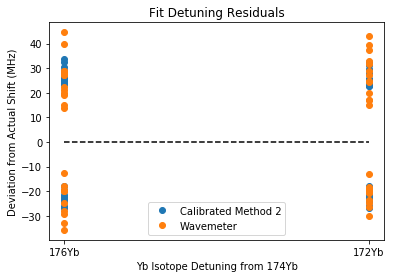

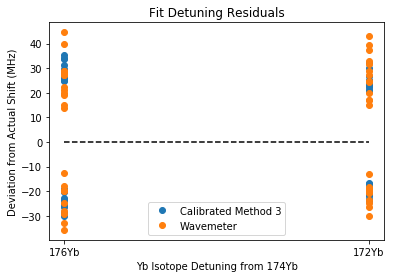

In [3]:
freq_calib = []
resid_calib = []
plotting = []
Yb = Yb_all[1:]
YbOH = YbOH_all[1:]
wavemeter = wavemeter_freqs[1:]

for i in range(2):
    _freq,_resid,_plot = calib556_array(Yb, method=i+2,compare=wavemeter,plot=False,verbose=False,fig=i)
    freq_calib.append(_freq)
    resid_calib.append(_resid)
    plotting.append(_plot)
freq_calib_methods = freq_calib

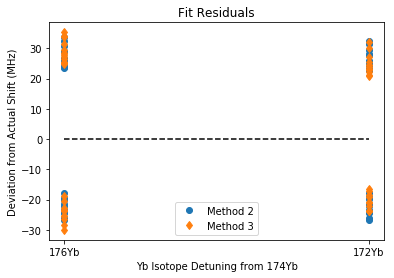

In [4]:
plt.figure(10)
plt.title('Fit Residuals')
xticks = [0,1]
plt.plot(xticks,np.zeros(len(xticks)),linestyle='--',color='black')
xlabel = ['176Yb','172Yb']
plt.xticks(xticks,xlabel)
plt.ylabel('Deviation from Actual Shift (MHz)')
plt.xlabel('Yb Isotope Detuning from 174Yb')
for i in range(2):
    if i==0:
        marker='o'
    else:
        marker='d'
    plt.plot(plotting[i][0],plotting[i][1],label = 'Method {}'.format(i+2),marker=marker,linestyle='None')
plt.legend(loc='lower center')

Use method 3 for now. Now, we have to shift the peaks to 0, as the calibration can introduce offsets. 

In [5]:
freq_calib = freq_calib_methods[-1]
freq_unshifted = freq_calib

Now, we have to shift the peaks to 0, as the calibration can introduce offsets. 

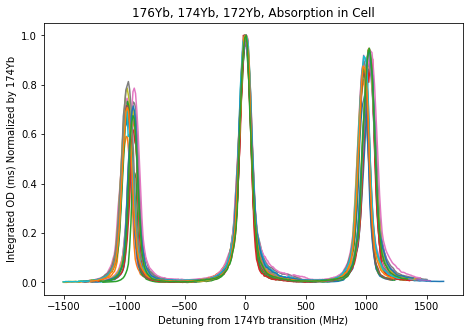

In [6]:
freq_calib = []
for _Yb,_freq_un in zip(Yb,freq_unshifted):
    _freq,_mean,_err = shift3Gaussians_2Zero(_freq_un,_Yb)
    plt.figure(1,figsize=(7.5,5))
    plt.plot(_freq,_Yb/np.amax(_Yb))
    plt.title('176Yb, 174Yb, 172Yb, Absorption in Cell')
    plt.xlabel('Detuning from 174Yb transition (MHz)')
    plt.ylabel('Integrated OD (ms) Normalized by 174Yb')
    freq_calib.append(_freq)
freq_calib = np.array(freq_calib);

Now we want to consider the YbOH data. First we will separate the data into 3 categories:

1) YbOH with enhancement blocked

2) YbOH with enhancement collinear with YAG/through snorkel

3) YbOH with longitduinal enhancement

In [7]:
#Scans that have the enhancement light blocked: 
#3,4,7,8,13,20 (remember this indexing starts from 1!) (also remember we took out the first trace!)

blocked = np.array([2, 3, 6, 7, 12, 19])-1

freq_ub = []
YbOH_ub = []
Yb_ub = []
freq_b = []
YbOH_b = []
Yb_b = []
    

for i,_freq,_YbOH,_Yb in zip(range(len(freq_calib)),freq_calib,YbOH,Yb):
    if i not in blocked:
        freq_ub.append(_freq)
        YbOH_ub.append(_YbOH)
        Yb_ub.append(_Yb)
    else:
        freq_b.append(_freq)
        YbOH_b.append(_YbOH)
        Yb_b.append(_Yb) 

#Now to separate longtiduinal from the rest. The last 8 are longitudinal

freq_long = freq_ub[-8:]
freq_other = freq_ub[:-8]
Yb_long = Yb_ub[-8:]
Yb_other = Yb_ub[:-8]
YbOH_long = YbOH_ub[-8:]
YbOH_other = YbOH_ub[:-8]

Now we can plot the YbOH traces on top of each other. However, because they have differing background levels, we have to first fit to a gaussian, then subtract the offset. We can also use the fit to calculate the enhancement factor as Max/Offset

In [8]:
param_container = []
enhance_container = []
subtracted_container = []

for _freq,_YbOH in zip(freq_long,YbOH_long):
    
    results = fitGaussian(_freq,_YbOH,[100,0,_YbOH.max(),_YbOH.min()],plot=False,verbose=False)
    params = results[0]
    errors = results[1]
    gmax = params[2]
    gmax_err = errors[2]
    offset = params[3]
    offset_err = errors[3]
    enhancement = np.round((gmax + offset)/offset,decimals=3)
    enhancement_err = np.round(np.sqrt((-gmax/offset**2 *offset_err)**2 + (1/offset * gmax_err)),decimals=3)
    all_data = np.array([params,errors])
    param_container.append(all_data)
    all_enhance = np.array([enhancement, enhancement_err])
    enhance_container.append(all_enhance)
    print('Enhancement = {} +/- {}'.format(enhancement,enhancement_err))
    _sub = _YbOH - offset
    subtracted_container.append(_sub)
                              
YbOH_l_params = np.array(param_container)
YbOH_l_enhancement = np.array(enhance_container)
YbOH_l_sub = np.array(subtracted_container)

Enhancement = 3.125 +/- 0.236
Enhancement = 2.817 +/- 0.219
Enhancement = 2.902 +/- 0.206
Enhancement = 2.794 +/- 0.206
Enhancement = 2.004 +/- 0.194
Enhancement = 2.057 +/- 0.176
Enhancement = 1.693 +/- 0.156
Enhancement = 1.63 +/- 0.176


Average Enhancement = 2.37775 +/- 0.5556536128740639
Average StDev = 107.39785162499999 +/- 13.184104566727035
Average Mean = -4.379955875 +/- 13.48433014318118


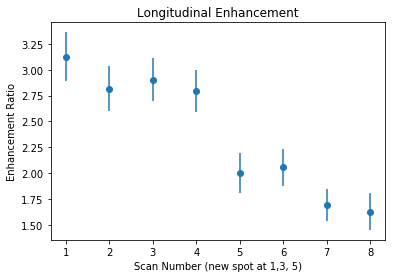

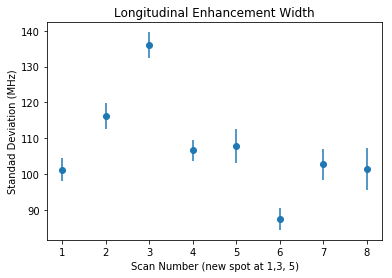

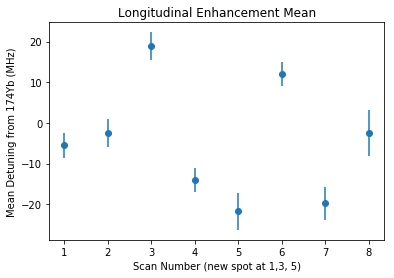

In [9]:
enhance = YbOH_l_enhancement[:,0]
en_err = YbOH_l_enhancement[:,1]
stdev = YbOH_l_params[:,0,0]
stdev_err = YbOH_l_params[:,1,0]
mean = YbOH_l_params[:,0,1]
mean_err = YbOH_l_params[:,1,1]

plt.figure()
plt.errorbar(np.arange(len(enhance))+1,enhance,yerr =en_err,marker='o',linestyle="None")
plt.title('Longitudinal Enhancement')
plt.xlabel('Scan Number (new spot at 1,3, 5)')
plt.ylabel('Enhancement Ratio')
print('Average Enhancement = {} +/- {}'.format(enhance.mean(),enhance.std()))

plt.figure()
plt.errorbar(np.arange(len(stdev))+1,stdev,yerr =stdev_err,marker='o',linestyle="None")
plt.title('Longitudinal Enhancement Width')
plt.xlabel('Scan Number (new spot at 1,3, 5)')
plt.ylabel('Standad Deviation (MHz)')
print('Average StDev = {} +/- {}'.format(stdev.mean(),stdev.std()))

plt.figure()
plt.errorbar(np.arange(len(mean))+1,mean,yerr =mean_err,marker='o',linestyle="None")
plt.title('Longitudinal Enhancement Mean')
plt.xlabel('Scan Number (new spot at 1,3, 5)')
plt.ylabel('Mean Detuning from 174Yb (MHz)')
print('Average Mean = {} +/- {}'.format(mean.mean(),mean.std()))

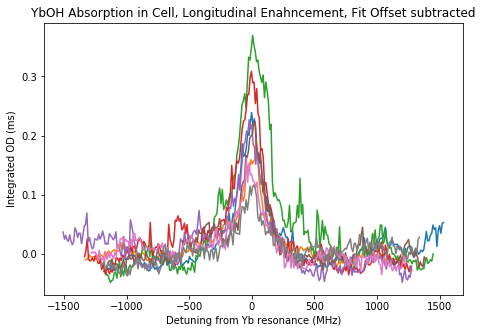

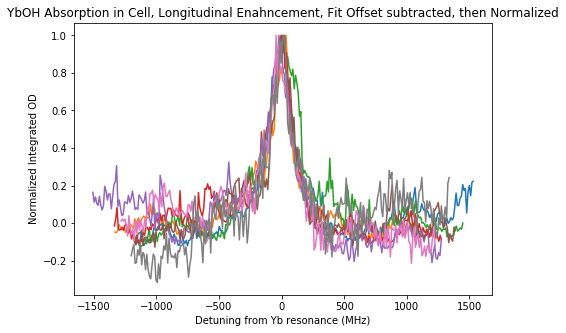

In [10]:
plt.figure(figsize=(7.5,5))
plt.title('YbOH Absorption in Cell, Longitudinal Enahncement, Fit Offset subtracted')
plt.xlabel('Detuning from Yb resonance (MHz)')
plt.ylabel('Integrated OD (ms)')
for _freq,_YbOH in zip(freq_long,YbOH_l_sub):
    plt.plot(_freq,_YbOH)
plt.figure(figsize=(7.5,5))
plt.title('YbOH Absorption in Cell, Longitudinal Enahncement, Fit Offset subtracted, then Normalized')
plt.xlabel('Detuning from Yb resonance (MHz)')
plt.ylabel('Normalized Integrated OD')
for _freq,_YbOH in zip(freq_long,YbOH_l_sub):
    plt.plot(_freq,_YbOH/_YbOH.max())

In [11]:
from math import ceil
def averageSpectra(freq_array,spectra_array,bin_size=10):
    freq_array = np.array(freq_array)
    spectra_array = np.array(spectra_array)
    pos = freq_array[:][-1].max()
    neg = freq_array[:][0].min()
    num_bins = int(ceil((pos-neg)/bin_size))
    bins = np.arange(neg,pos,bin_size)
    _sum = np.zeros(len(bins))
    num_avg = np.zeros(len(bins))
    for i in range(len(bins)):
        for j in range(len(freq_array)):
            for k in range(len(freq_array[j])):
                if bins[i] <= freq_array[j][k] < bins[i] + bin_size:
                    _sum[i]+= spectra_array[j][k]
                    num_avg[i]+=1
    avg_spectra = _sum/num_avg
    return [bins,avg_spectra]



Fit error =  [2.002335e+00 1.906892e+00 2.912000e-03 7.490000e-04]
FIT PARAMS =  [ 1.11106837e+02 -8.03296400e+00  1.92615000e-01 -5.79000000e-04]
Mean = -8.032964 +/- 1.906892 MHz, StDev = 111.106837 +/- 2.002335 MHz


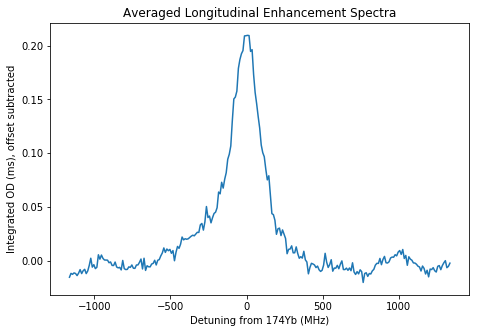

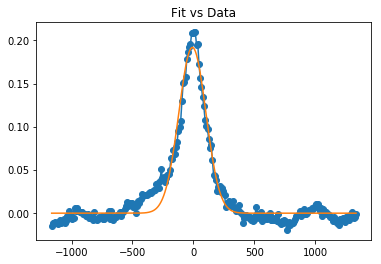

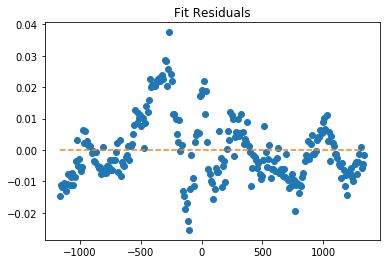

In [12]:
bins,avg = averageSpectra(freq_long,YbOH_l_sub,bin_size=10)
plt.figure(figsize=(7.5,5))
plt.title('Averaged Longitudinal Enhancement Spectra')
plt.xlabel('Detuning from 174Yb (MHz)')
plt.ylabel('Integrated OD (ms), offset subtracted')
plt.plot(bins,avg)
params,err,resid = fitGaussian(bins,avg,[100,0,0.2,0],verbose=True,plot=True);



Fit error =  [2.038767 1.944626 0.013128 0.003321]
FIT PARAMS =  [ 1.08229401e+02 -9.47899000e+00  8.30066000e-01 -2.31000000e-03]
Mean = -9.47899 +/- 1.944626 MHz, StDev = 108.229401 +/- 2.038767 MHz


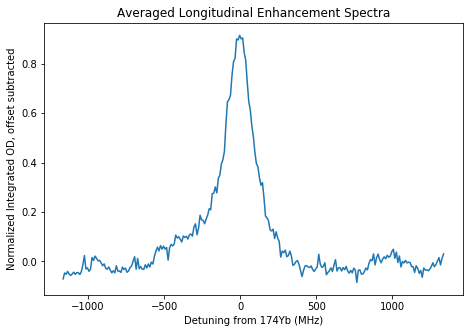

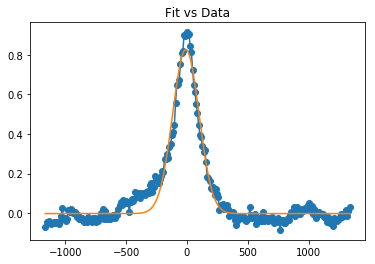

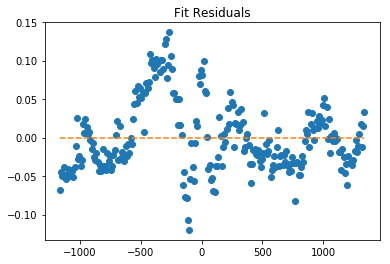

In [13]:
YbOH_l_sub_norm = []
for _YbOH in YbOH_l_sub:
    YbOH_l_sub_norm.append(_YbOH/_YbOH.max())
bins,avg = averageSpectra(freq_long,YbOH_l_sub_norm,bin_size=10)
plt.figure(figsize=(7.5,5))
plt.title('Averaged Longitudinal Enhancement Spectra')
plt.xlabel('Detuning from 174Yb (MHz)')
plt.ylabel('Normalized Integrated OD, offset subtracted')
plt.plot(bins,avg)
params,err,resid = fitGaussian(bins,avg,[100,0,0.2,0],verbose=True,plot=True);

Now we can do the same for the other data (not longitudinal)

In [14]:
param_container = []
enhance_container = []
subtracted_container = []

for _freq,_YbOH in zip(freq_other,YbOH_other):
    
    results = fitGaussian(_freq,_YbOH,[100,0,_YbOH.max(),_YbOH.min()],plot=False,verbose=False)
    params = results[0]
    errors = results[1]
    gmax = params[2]
    gmax_err = errors[2]
    offset = params[3]
    offset_err = errors[3]
    enhancement = np.round((gmax + offset)/offset,decimals=3)
    enhancement_err = np.round(np.sqrt((-gmax/offset**2 *offset_err)**2 + (1/offset * gmax_err)),decimals=3)
    all_data = np.array([params,errors])
    param_container.append(all_data)
    all_enhance = np.array([enhancement, enhancement_err])
    enhance_container.append(all_enhance)
    print('Enhancement = {} +/- {}'.format(enhancement,enhancement_err))
    _sub = _YbOH - offset
    subtracted_container.append(_sub)
                              
YbOH_o_params = np.array(param_container)
YbOH_o_enhancement = np.array(enhance_container)
YbOH_o_sub = np.array(subtracted_container)

Enhancement = 1.628 +/- 0.199
Enhancement = 1.404 +/- 0.189
Enhancement = 1.586 +/- 0.161
Enhancement = 1.515 +/- 0.171
Enhancement = 1.504 +/- 0.152
Enhancement = 1.447 +/- 0.189
Enhancement = 1.545 +/- 0.183
Enhancement = 1.294 +/- 0.169
Enhancement = 1.378 +/- 0.176


Average Enhancement = 1.4778888888888888 +/- 0.10054898689411096
Average StDev = 107.66416944444444 +/- 27.13431612094544
Average Mean = -12.145839777777779 +/- 8.547131969583257


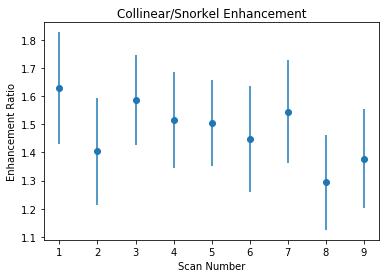

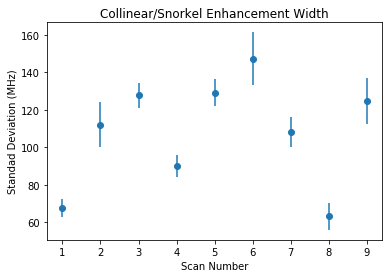

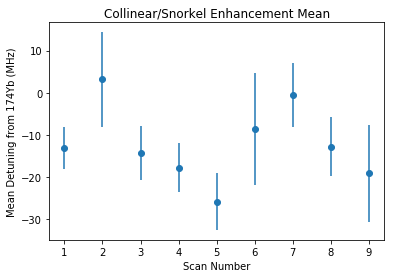

In [15]:
enhance = YbOH_o_enhancement[:,0]
en_err = YbOH_o_enhancement[:,1]
stdev = YbOH_o_params[:,0,0]
stdev_err = YbOH_o_params[:,1,0]
mean = YbOH_o_params[:,0,1]
mean_err = YbOH_o_params[:,1,1]

plt.figure()
plt.errorbar(np.arange(len(enhance))+1,enhance,yerr =en_err,marker='o',linestyle="None")
plt.title('Collinear/Snorkel Enhancement')
plt.xlabel('Scan Number')
plt.ylabel('Enhancement Ratio')
print('Average Enhancement = {} +/- {}'.format(enhance.mean(),enhance.std()))

plt.figure()
plt.errorbar(np.arange(len(stdev))+1,stdev,yerr =stdev_err,marker='o',linestyle="None")
plt.title('Collinear/Snorkel Enhancement Width')
plt.xlabel('Scan Number')
plt.ylabel('Standad Deviation (MHz)')
print('Average StDev = {} +/- {}'.format(stdev.mean(),stdev.std()))

plt.figure()
plt.errorbar(np.arange(len(mean))+1,mean,yerr =mean_err,marker='o',linestyle="None")
plt.title('Collinear/Snorkel Enhancement Mean')
plt.xlabel('Scan Number')
plt.ylabel('Mean Detuning from 174Yb (MHz)')
print('Average Mean = {} +/- {}'.format(mean.mean(),mean.std()))

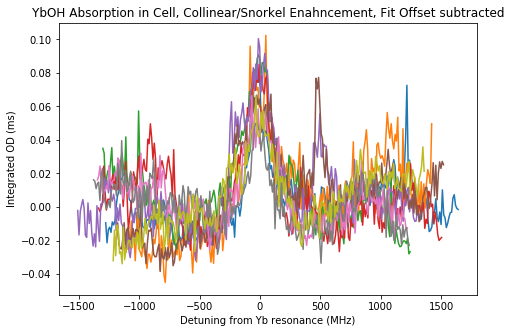

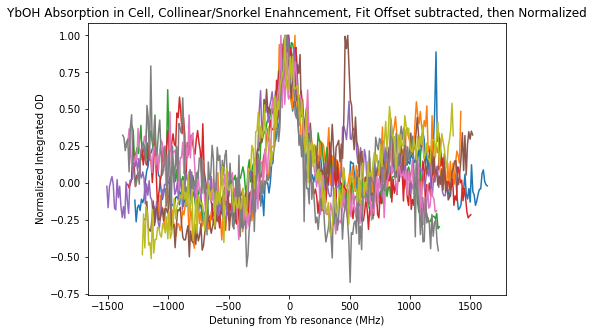

In [16]:
plt.figure(figsize=(7.5,5))
plt.title('YbOH Absorption in Cell, Collinear/Snorkel Enahncement, Fit Offset subtracted')
plt.xlabel('Detuning from Yb resonance (MHz)')
plt.ylabel('Integrated OD (ms)')
for _freq,_YbOH in zip(freq_other,YbOH_o_sub):
    plt.plot(_freq,_YbOH)
plt.figure(figsize=(7.5,5))
plt.title('YbOH Absorption in Cell, Collinear/Snorkel Enahncement, Fit Offset subtracted, then Normalized')
plt.xlabel('Detuning from Yb resonance (MHz)')
plt.ylabel('Normalized Integrated OD')
for _freq,_YbOH in zip(freq_other,YbOH_o_sub):
    plt.plot(_freq,_YbOH/_YbOH.max())



Fit error =  [3.851216e+00 3.687346e+00 1.973000e-03 4.780000e-04]
FIT PARAMS =  [ 1.06338932e+02 -1.69303270e+01  6.47200000e-02  3.26000000e-04]
Mean = -16.930327 +/- 3.687346 MHz, StDev = 106.338932 +/- 3.851216 MHz


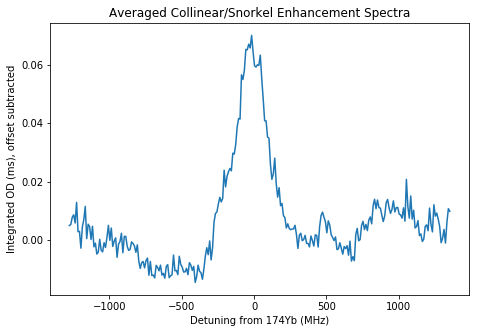

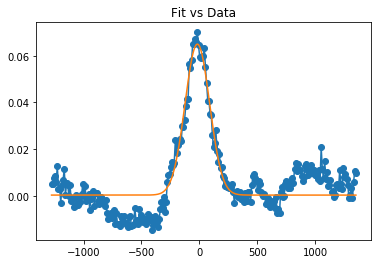

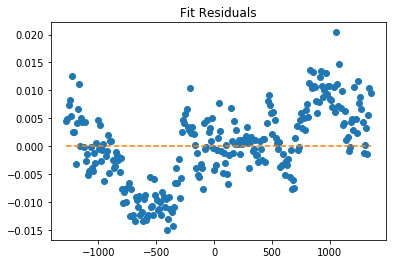

In [17]:
bins,avg = averageSpectra(freq_other,YbOH_o_sub,bin_size=10)
plt.figure(figsize=(7.5,5))
plt.title('Averaged Collinear/Snorkel Enhancement Spectra')
plt.xlabel('Detuning from 174Yb (MHz)')
plt.ylabel('Integrated OD (ms), offset subtracted')
plt.plot(bins,avg)
params,err,resid = fitGaussian(bins,avg,[100,0,0.2,0],verbose=True,plot=True);



Fit error =  [3.759138 3.603687 0.024724 0.005907]
FIT PARAMS =  [ 1.03822217e+02 -1.67446570e+01  8.10674000e-01  3.79200000e-03]
Mean = -16.744657 +/- 3.603687 MHz, StDev = 103.822217 +/- 3.759138 MHz


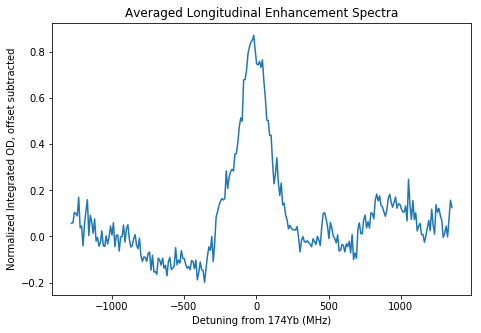

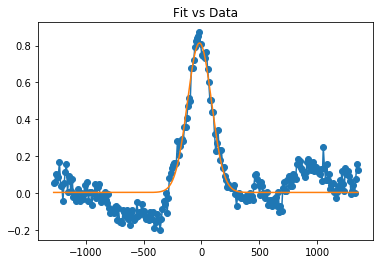

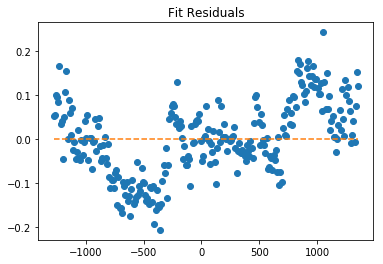

In [18]:
YbOH_o_sub_norm = []
for _YbOH in YbOH_o_sub:
    YbOH_o_sub_norm.append(_YbOH/_YbOH.max())
bins,avg = averageSpectra(freq_other,YbOH_o_sub_norm,bin_size=10)
plt.figure(figsize=(7.5,5))
plt.title('Averaged Longitudinal Enhancement Spectra')
plt.xlabel('Detuning from 174Yb (MHz)')
plt.ylabel('Normalized Integrated OD, offset subtracted')
plt.plot(bins,avg)
params,err,resid = fitGaussian(bins,avg,[100,0,0.2,0],verbose=True,plot=True);